# Keras: Boston House prices

we will attempt the Boston House prices regression problem

first, we import our main math stuff

In [2]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn-pastel')
import math

now, we load our dataset

In [3]:
from keras.datasets import boston_housing

# load data
(x_data, y_data), (x_test, y_test) = boston_housing.load_data()

print('training data shape:', x_data.shape)

training data shape: (404, 13)


let's do a sanity check on the data

In [4]:
print('training data shape:', x_data.shape)

training data shape: (404, 13)


now, we're going to prepare our data

In [5]:
import keras

# feature normalization
mean = x_data.mean(axis=0)
x_data -= mean
std = x_data.std(axis=0)
x_data /= std
x_test -= mean
x_test /= std

and now prepare our model:

In [6]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(96, activation='selu', input_shape=(x_data.shape[1],)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(64, activation='selu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(1))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

build_model().summary()

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 96)                1344      
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                6208      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 7,617
Trainable params: 7,617
Non-trainable params: 0
_________________________________________________________________


model evaluation using K-Fold cross validation

100%|██████████| 400/400 [00:28<00:00, 14.21epoch/s, val_loss=7.86, val_mean_absolute_error=2.1, loss=12.4, mean_absolute_error=2.61]


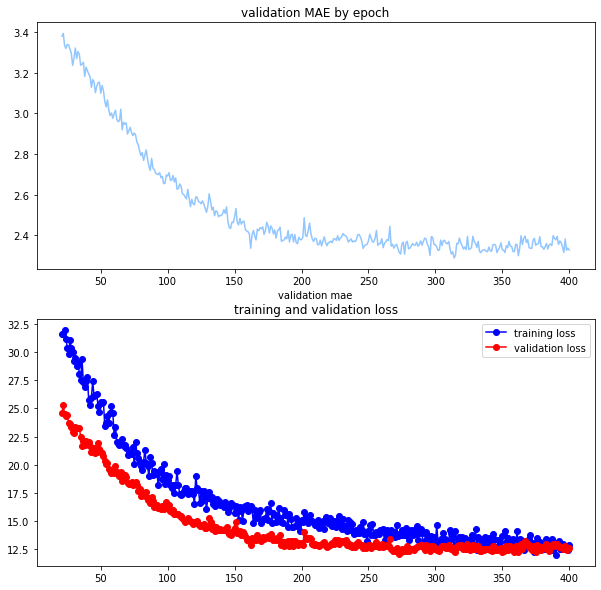

In [7]:
from sklearn.model_selection import KFold
from tqdm.keras import TqdmCallback

kfold_epochs = 400
kfold_splits = 6

mae_history = []
loss_history = []
val_loss_history = []

print(f'performing K-fold cross validation: {kfold_splits} splits, {kfold_epochs} epochs...')

kfold = KFold(n_splits=kfold_splits, shuffle=True)
for train_i, val_i in kfold.split(x_data):
    model = build_model()
    hist = model.fit(x_data[train_i], y_data[train_i], validation_data=(x_data[val_i], y_data[val_i]), epochs=kfold_epochs, batch_size=16, verbose=0, callbacks=[TqdmCallback(verbose=0)])

    mae_history.append(hist.history['val_mean_absolute_error'])
    loss_history.append(hist.history['loss'])
    val_loss_history.append(hist.history['val_loss'])

# get the mean of each step across all k runs
mae_history_np = np.array(mae_history)
mean_mae_history = np.mean(mae_history, axis=0)
loss_history_np = np.mean(np.array(loss_history), axis=0)
val_loss_history_np = np.mean(np.array(val_loss_history), axis=0)

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

plot_epoch_start = 20
epoch_range = range(plot_epoch_start + 1, mean_mae_history.shape[0] + 1)

ax[0].plot(epoch_range, mean_mae_history[plot_epoch_start:])
ax[0].set_title("validation MAE by epoch")
ax[0].set_xlabel("epochs")
ax[0].set_xlabel("validation mae")

ax[1].plot(epoch_range, loss_history_np[plot_epoch_start:], 'bo-', label='training loss')
ax[1].plot(epoch_range, val_loss_history_np[plot_epoch_start:], 'ro-', label='validation loss')
ax[1].set_title('training and validation loss')
ax[1].legend()

and now, we train our model

In [9]:
from tqdm.keras import TqdmCallback

batch_size = 16
epochs = 320

model = build_model()
model.fit(x_data, y_data,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          callbacks=[TqdmCallback(verbose=0)])

test_mse, test_mae = model.evaluate(x_test, y_test, verbose=0)
print('Test mse:', test_mse)
print('Test mae:', test_mae)

100%|██████████| 320/320 [00:24<00:00, 13.32epoch/s, loss=12.7, mean_absolute_error=2.7]
Test mse: 17.53922555960861
Test mae: 2.7620049270929075
